In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/stk-lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/stk-lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/stk-lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1308

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

72

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 2000,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

In [11]:
# path of oof predictions
path1 = "../data/oof/lgbm-dart-bce-dsv06"
path2 = "../data/oof/lgbm-dart-xtree-bce-dsv06"
path3 = "../data/oof/xgboost-dsv06"
path4 = "../data/oof/catboost-dsv06"

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.793472	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.922172


[100]	valid_0's amex_metric: 0.794917	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.923041


[150]	valid_0's amex_metric: 0.795671	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924045


[200]	valid_0's amex_metric: 0.796674	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.924956


[250]	valid_0's amex_metric: 0.797413	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925424


[300]	valid_0's amex_metric: 0.79854	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925743


[350]	valid_0's amex_metric: 0.798731	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925873


[400]	valid_0's amex_metric: 0.79859	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925927


[450]	valid_0's amex_metric: 0.798941	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925955


[500]	valid_0's amex_metric: 0.798941	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925955


[550]	valid_0's amex_metric: 0.798529	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925931


[600]	valid_0's amex_metric: 0.799049	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925961


[650]	valid_0's amex_metric: 0.798919	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925953


[700]	valid_0's amex_metric: 0.798868	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925935


[750]	valid_0's amex_metric: 0.798777	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925922


[800]	valid_0's amex_metric: 0.79857	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925887


[850]	valid_0's amex_metric: 0.798543	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.925876


[900]	valid_0's amex_metric: 0.798388	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925902


[950]	valid_0's amex_metric: 0.798464	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925885


[1000]	valid_0's amex_metric: 0.798437	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925874


[1050]	valid_0's amex_metric: 0.798701	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925855


[1100]	valid_0's amex_metric: 0.798608	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925837


[1150]	valid_0's amex_metric: 0.798414	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925827


[1200]	valid_0's amex_metric: 0.798126	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925799


[1250]	valid_0's amex_metric: 0.798803	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925763


[1300]	valid_0's amex_metric: 0.79859	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925759


[1350]	valid_0's amex_metric: 0.798286	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.92574


[1400]	valid_0's amex_metric: 0.798149	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925719


[1450]	valid_0's amex_metric: 0.798691	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925708


[1500]	valid_0's amex_metric: 0.798364	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925686


[1550]	valid_0's amex_metric: 0.798262	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.92565


[1600]	valid_0's amex_metric: 0.798051	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925648


[1650]	valid_0's amex_metric: 0.797679	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925619


[1700]	valid_0's amex_metric: 0.79747	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.92558


[1750]	valid_0's amex_metric: 0.797745	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925583


[1800]	valid_0's amex_metric: 0.797753	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925558


[1850]	valid_0's amex_metric: 0.797777	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925521


[1900]	valid_0's amex_metric: 0.797845	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925489


[1950]	valid_0's amex_metric: 0.797817	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925476


[2000]	valid_0's amex_metric: 0.797509	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925448


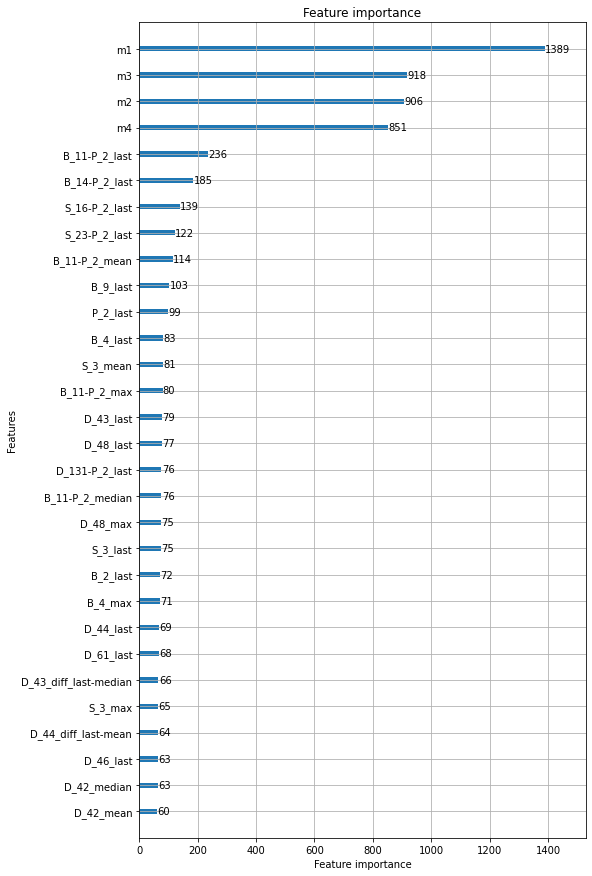

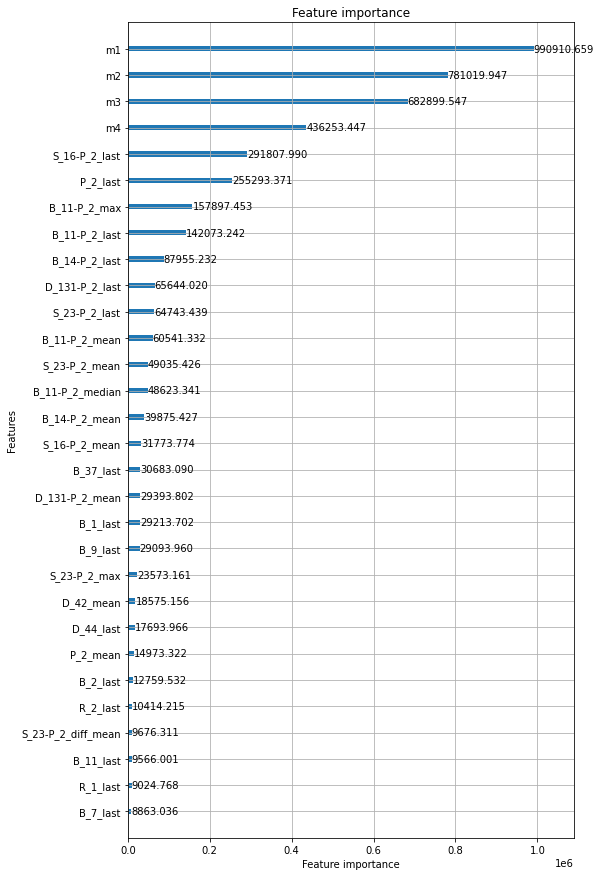

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.791684	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.921456


[100]	valid_0's amex_metric: 0.793424	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.922244


[150]	valid_0's amex_metric: 0.795173	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.923216


[200]	valid_0's amex_metric: 0.797102	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.924213


[250]	valid_0's amex_metric: 0.796413	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924687


[300]	valid_0's amex_metric: 0.797517	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925043


[350]	valid_0's amex_metric: 0.79758	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925212


[400]	valid_0's amex_metric: 0.798011	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925359


[450]	valid_0's amex_metric: 0.798416	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925453


[500]	valid_0's amex_metric: 0.798532	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925475


[550]	valid_0's amex_metric: 0.798696	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925507


[600]	valid_0's amex_metric: 0.798406	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925559


[650]	valid_0's amex_metric: 0.798501	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925622


[700]	valid_0's amex_metric: 0.798562	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925619


[750]	valid_0's amex_metric: 0.798631	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.92563


[800]	valid_0's amex_metric: 0.79926	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925625


[850]	valid_0's amex_metric: 0.799065	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925615


[900]	valid_0's amex_metric: 0.799202	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925595


[950]	valid_0's amex_metric: 0.79843	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.925565


[1000]	valid_0's amex_metric: 0.798209	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925543


[1050]	valid_0's amex_metric: 0.798531	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925556


[1100]	valid_0's amex_metric: 0.799005	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.92558


[1150]	valid_0's amex_metric: 0.799063	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925568


[1200]	valid_0's amex_metric: 0.799204	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925556


[1250]	valid_0's amex_metric: 0.799049	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92554


[1300]	valid_0's amex_metric: 0.798419	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925501


[1350]	valid_0's amex_metric: 0.798942	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925495


[1400]	valid_0's amex_metric: 0.798764	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925475


[1450]	valid_0's amex_metric: 0.798632	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925464


[1500]	valid_0's amex_metric: 0.798277	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.92547


[1550]	valid_0's amex_metric: 0.798039	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925415


[1600]	valid_0's amex_metric: 0.798095	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.9254


[1650]	valid_0's amex_metric: 0.798762	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925387


[1700]	valid_0's amex_metric: 0.798775	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925371


[1750]	valid_0's amex_metric: 0.798536	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925357


[1800]	valid_0's amex_metric: 0.798601	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925317


[1850]	valid_0's amex_metric: 0.798647	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925283


[1900]	valid_0's amex_metric: 0.799112	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925288


[1950]	valid_0's amex_metric: 0.799309	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.925262


[2000]	valid_0's amex_metric: 0.799298	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.925239


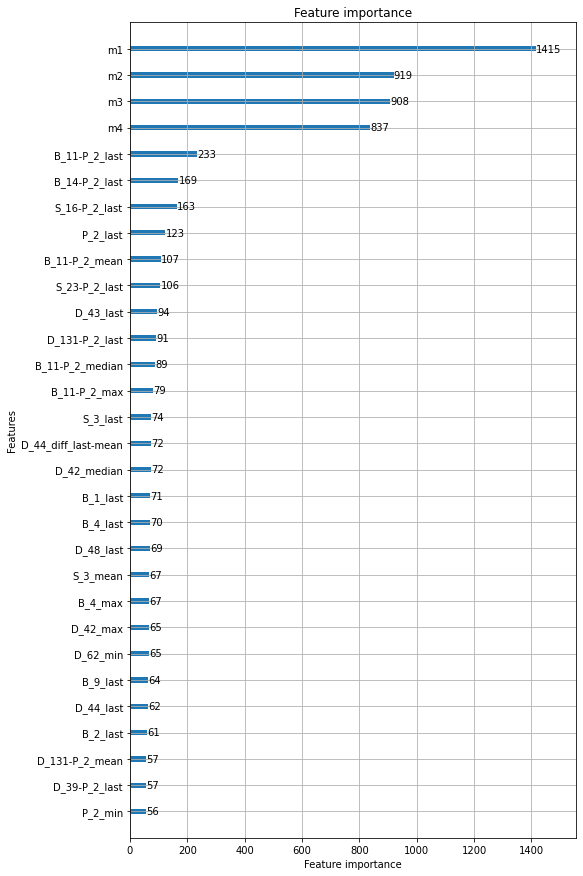

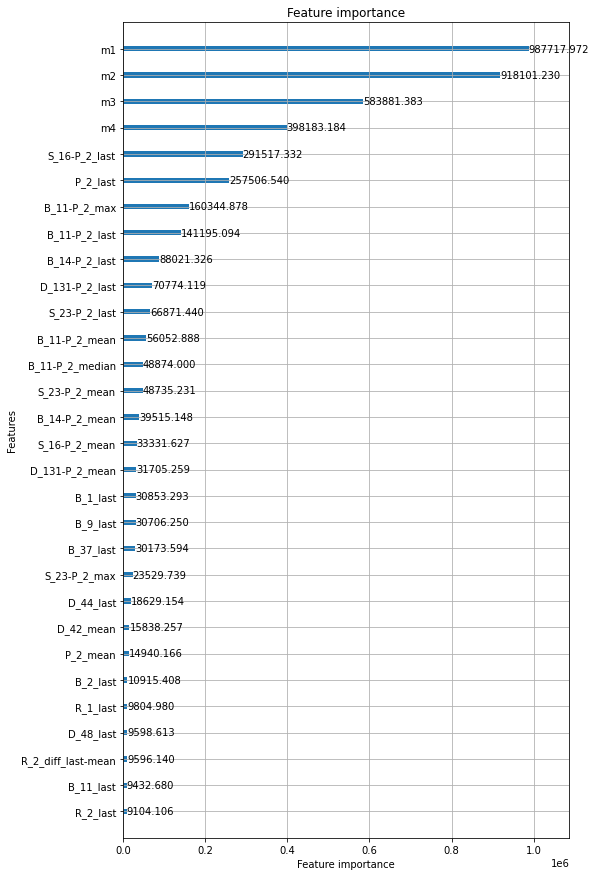

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.788225	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.920302


[100]	valid_0's amex_metric: 0.788707	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.921393


[150]	valid_0's amex_metric: 0.790906	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.922256


[200]	valid_0's amex_metric: 0.792446	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.923064


[250]	valid_0's amex_metric: 0.793253	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923459


[300]	valid_0's amex_metric: 0.793099	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92374


[350]	valid_0's amex_metric: 0.792597	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.923872


[400]	valid_0's amex_metric: 0.792799	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923981


[450]	valid_0's amex_metric: 0.792643	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.924048


[500]	valid_0's amex_metric: 0.792827	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924036


[550]	valid_0's amex_metric: 0.792571	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.92403


[600]	valid_0's amex_metric: 0.79235	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.92405


[650]	valid_0's amex_metric: 0.792249	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924059


[700]	valid_0's amex_metric: 0.792204	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924054


[750]	valid_0's amex_metric: 0.792368	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.924045


[800]	valid_0's amex_metric: 0.792106	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.924025


[850]	valid_0's amex_metric: 0.792237	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923993


[900]	valid_0's amex_metric: 0.792487	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923988


[950]	valid_0's amex_metric: 0.792353	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.92393


[1000]	valid_0's amex_metric: 0.791925	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923915


[1050]	valid_0's amex_metric: 0.792445	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923905


[1100]	valid_0's amex_metric: 0.791675	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.923879


[1150]	valid_0's amex_metric: 0.791773	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923863


[1200]	valid_0's amex_metric: 0.79159	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.923834


[1250]	valid_0's amex_metric: 0.791663	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923812


[1300]	valid_0's amex_metric: 0.792011	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.923794


[1350]	valid_0's amex_metric: 0.791851	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923768


[1400]	valid_0's amex_metric: 0.791414	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923736


[1450]	valid_0's amex_metric: 0.791529	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.923712


[1500]	valid_0's amex_metric: 0.791286	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.92369


[1550]	valid_0's amex_metric: 0.791651	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923662


[1600]	valid_0's amex_metric: 0.791203	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.923649


[1650]	valid_0's amex_metric: 0.791656	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.92363


[1700]	valid_0's amex_metric: 0.791459	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.923616


[1750]	valid_0's amex_metric: 0.79139	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.923604


[1800]	valid_0's amex_metric: 0.79131	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.92357


[1850]	valid_0's amex_metric: 0.791537	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923561


[1900]	valid_0's amex_metric: 0.791958	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.92356


[1950]	valid_0's amex_metric: 0.791995	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.92355


[2000]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.923524


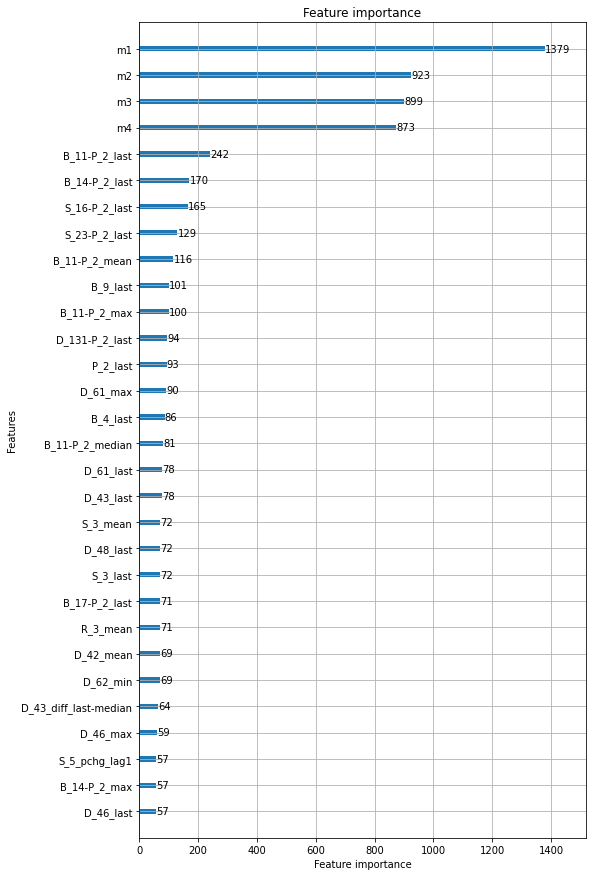

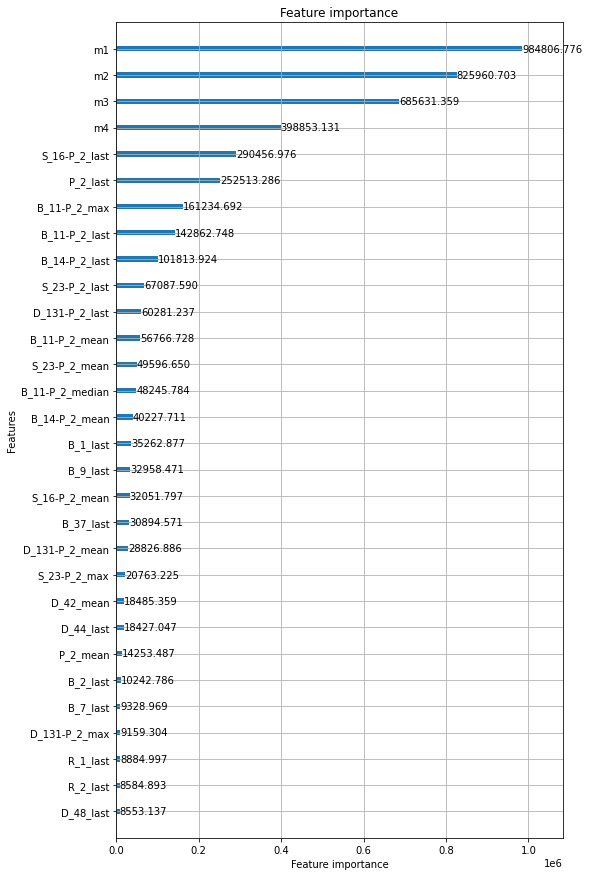

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.787162	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.920253


[100]	valid_0's amex_metric: 0.789264	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.921259


[150]	valid_0's amex_metric: 0.789809	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.922181


[200]	valid_0's amex_metric: 0.791432	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.923155


[250]	valid_0's amex_metric: 0.791727	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.923659


[300]	valid_0's amex_metric: 0.792416	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.92407


[350]	valid_0's amex_metric: 0.792899	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.924237


[400]	valid_0's amex_metric: 0.792859	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.924409


[450]	valid_0's amex_metric: 0.792494	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924478


[500]	valid_0's amex_metric: 0.792596	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924472


[550]	valid_0's amex_metric: 0.792393	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924446


[600]	valid_0's amex_metric: 0.792389	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.92448


[650]	valid_0's amex_metric: 0.793011	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.924503


[700]	valid_0's amex_metric: 0.792989	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.924502


[750]	valid_0's amex_metric: 0.792382	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.924507


[800]	valid_0's amex_metric: 0.793064	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.924524


[850]	valid_0's amex_metric: 0.79273	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924531


[900]	valid_0's amex_metric: 0.792722	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924556


[950]	valid_0's amex_metric: 0.792654	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.924546


[1000]	valid_0's amex_metric: 0.79267	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924537


[1050]	valid_0's amex_metric: 0.791999	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.924541


[1100]	valid_0's amex_metric: 0.792266	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924571


[1150]	valid_0's amex_metric: 0.792265	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924568


[1200]	valid_0's amex_metric: 0.792235	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.92455


[1250]	valid_0's amex_metric: 0.791985	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924555


[1300]	valid_0's amex_metric: 0.792015	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.924531


[1350]	valid_0's amex_metric: 0.792244	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924526


[1400]	valid_0's amex_metric: 0.792155	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.924516


[1450]	valid_0's amex_metric: 0.791882	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.924475


[1500]	valid_0's amex_metric: 0.79186	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924473


[1550]	valid_0's amex_metric: 0.791978	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.924456


[1600]	valid_0's amex_metric: 0.79212	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.924445


[1650]	valid_0's amex_metric: 0.792197	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924431


[1700]	valid_0's amex_metric: 0.792388	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924434


[1750]	valid_0's amex_metric: 0.791879	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924384


[1800]	valid_0's amex_metric: 0.791284	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.924372


[1850]	valid_0's amex_metric: 0.791722	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.924365


[1900]	valid_0's amex_metric: 0.791117	valid_0's recall_at4: 0.657858	valid_0's norm_gini: 0.924376


[1950]	valid_0's amex_metric: 0.791088	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.924361


[2000]	valid_0's amex_metric: 0.79116	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.924335


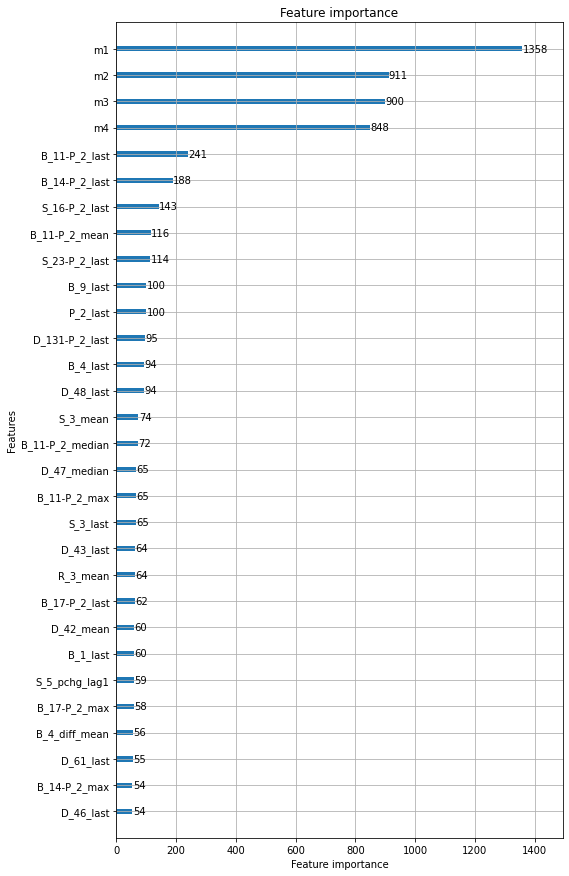

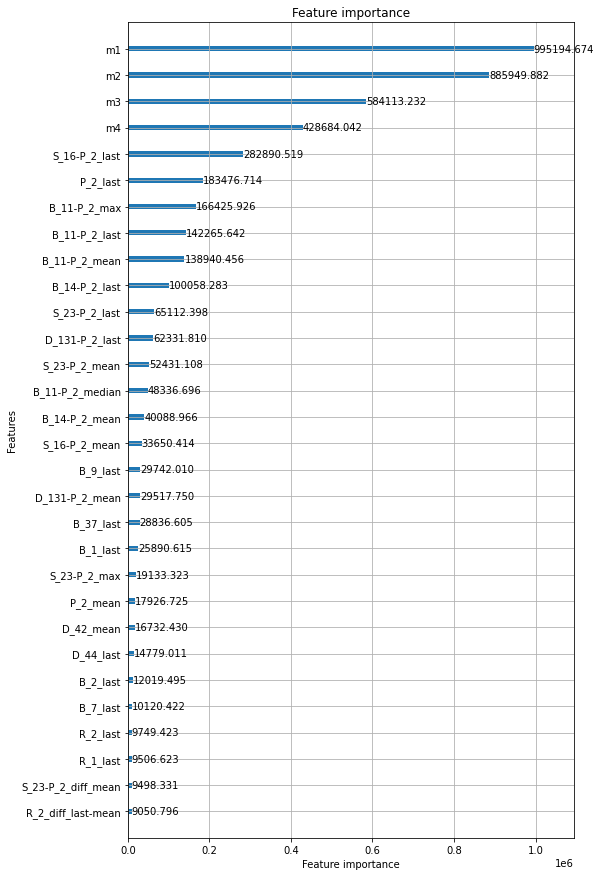

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.795781	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.923774


[100]	valid_0's amex_metric: 0.797409	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.924588


[150]	valid_0's amex_metric: 0.798272	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.925473


[200]	valid_0's amex_metric: 0.800449	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926376


[250]	valid_0's amex_metric: 0.800746	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.926844


[300]	valid_0's amex_metric: 0.80135	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.927168


[350]	valid_0's amex_metric: 0.801887	valid_0's recall_at4: 0.676415	valid_0's norm_gini: 0.927359


[400]	valid_0's amex_metric: 0.801727	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.92746


[450]	valid_0's amex_metric: 0.801679	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927532


[500]	valid_0's amex_metric: 0.801989	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927522


[550]	valid_0's amex_metric: 0.801696	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927524


[600]	valid_0's amex_metric: 0.801692	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927558


[650]	valid_0's amex_metric: 0.801751	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.92755


[700]	valid_0's amex_metric: 0.802005	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927553


[750]	valid_0's amex_metric: 0.801881	valid_0's recall_at4: 0.676205	valid_0's norm_gini: 0.927557


[800]	valid_0's amex_metric: 0.801833	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927546


[850]	valid_0's amex_metric: 0.801987	valid_0's recall_at4: 0.676415	valid_0's norm_gini: 0.927558


[900]	valid_0's amex_metric: 0.801878	valid_0's recall_at4: 0.676205	valid_0's norm_gini: 0.927552


[950]	valid_0's amex_metric: 0.801506	valid_0's recall_at4: 0.675489	valid_0's norm_gini: 0.927523


[1000]	valid_0's amex_metric: 0.801474	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.9275


[1050]	valid_0's amex_metric: 0.801789	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.9275


[1100]	valid_0's amex_metric: 0.801027	valid_0's recall_at4: 0.674563	valid_0's norm_gini: 0.927491


[1150]	valid_0's amex_metric: 0.801103	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.927475


[1200]	valid_0's amex_metric: 0.80087	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.927472


[1250]	valid_0's amex_metric: 0.801179	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927457


[1300]	valid_0's amex_metric: 0.80111	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927446


[1350]	valid_0's amex_metric: 0.801279	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927447


[1400]	valid_0's amex_metric: 0.801271	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927431


[1450]	valid_0's amex_metric: 0.800723	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.92743


[1500]	valid_0's amex_metric: 0.800673	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.927414


[1550]	valid_0's amex_metric: 0.801065	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.927399


[1600]	valid_0's amex_metric: 0.800728	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.927397


[1650]	valid_0's amex_metric: 0.800953	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.927385


[1700]	valid_0's amex_metric: 0.800337	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.927372


[1750]	valid_0's amex_metric: 0.80013	valid_0's recall_at4: 0.672922	valid_0's norm_gini: 0.927338


[1800]	valid_0's amex_metric: 0.800504	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.927328


[1850]	valid_0's amex_metric: 0.800747	valid_0's recall_at4: 0.674185	valid_0's norm_gini: 0.927309


[1900]	valid_0's amex_metric: 0.800507	valid_0's recall_at4: 0.673722	valid_0's norm_gini: 0.927293


[1950]	valid_0's amex_metric: 0.80073	valid_0's recall_at4: 0.674185	valid_0's norm_gini: 0.927276


[2000]	valid_0's amex_metric: 0.800055	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.927271


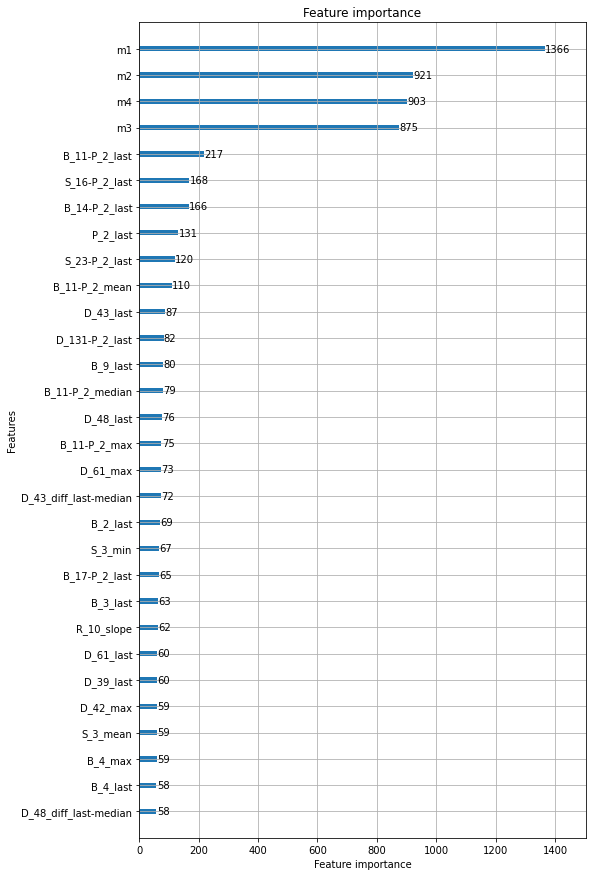

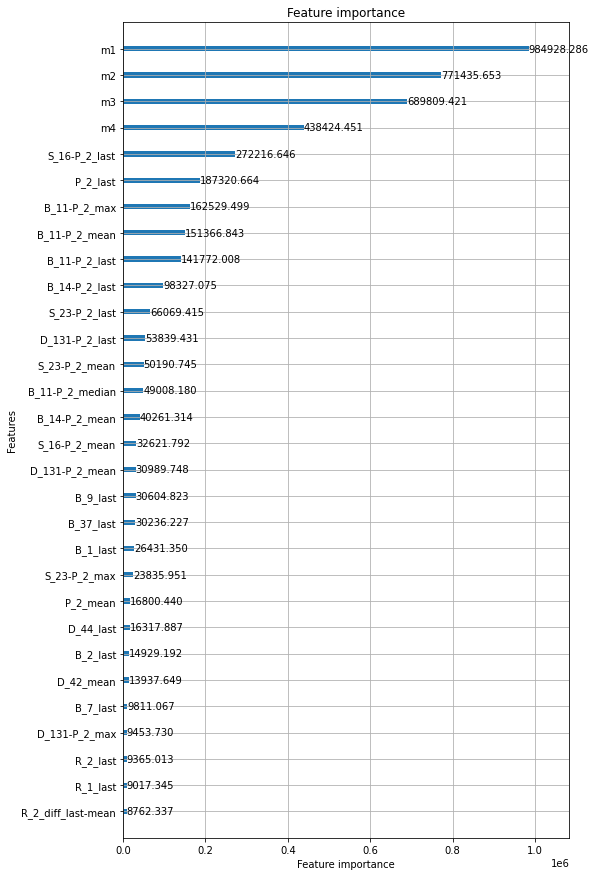

Training time: 19.987845607598622 min.


OOF recall_at4: 0.6668546133907833


OOF normalized_gini: 0.9250031204353419


OOF competition metric: 0.7959288669130626


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.794978	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.92249


[100]	valid_0's amex_metric: 0.794794	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.923342


[150]	valid_0's amex_metric: 0.797145	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924258


[200]	valid_0's amex_metric: 0.798958	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925233


[250]	valid_0's amex_metric: 0.799441	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925777


[300]	valid_0's amex_metric: 0.799932	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.92617


[350]	valid_0's amex_metric: 0.800668	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.926339


[400]	valid_0's amex_metric: 0.800872	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.926452


[450]	valid_0's amex_metric: 0.800523	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.92651


[500]	valid_0's amex_metric: 0.800855	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.926501


[550]	valid_0's amex_metric: 0.800697	valid_0's recall_at4: 0.674914	valid_0's norm_gini: 0.92648


[600]	valid_0's amex_metric: 0.80105	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.926513


[650]	valid_0's amex_metric: 0.800981	valid_0's recall_at4: 0.675419	valid_0's norm_gini: 0.926544


[700]	valid_0's amex_metric: 0.800898	valid_0's recall_at4: 0.67525	valid_0's norm_gini: 0.926545


[750]	valid_0's amex_metric: 0.800803	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926524


[800]	valid_0's amex_metric: 0.800845	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.926524


[850]	valid_0's amex_metric: 0.800792	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926503


[900]	valid_0's amex_metric: 0.800685	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.92654


[950]	valid_0's amex_metric: 0.80101	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.926516


[1000]	valid_0's amex_metric: 0.800981	valid_0's recall_at4: 0.675461	valid_0's norm_gini: 0.926502


[1050]	valid_0's amex_metric: 0.800367	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926494


[1100]	valid_0's amex_metric: 0.800221	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926497


[1150]	valid_0's amex_metric: 0.800297	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.926479


[1200]	valid_0's amex_metric: 0.800238	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926446


[1250]	valid_0's amex_metric: 0.800272	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.92643


[1300]	valid_0's amex_metric: 0.799807	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926426


[1350]	valid_0's amex_metric: 0.800204	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.92642


[1400]	valid_0's amex_metric: 0.80029	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926424


[1450]	valid_0's amex_metric: 0.800245	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926418


[1500]	valid_0's amex_metric: 0.800385	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.926402


[1550]	valid_0's amex_metric: 0.799941	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926399


[1600]	valid_0's amex_metric: 0.799643	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926391


[1650]	valid_0's amex_metric: 0.799746	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926345


[1700]	valid_0's amex_metric: 0.800282	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926324


[1750]	valid_0's amex_metric: 0.800194	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926315


[1800]	valid_0's amex_metric: 0.800372	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.926293


[1850]	valid_0's amex_metric: 0.80011	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926275


[1900]	valid_0's amex_metric: 0.800223	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926248


[1950]	valid_0's amex_metric: 0.800416	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926254


[2000]	valid_0's amex_metric: 0.800138	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926246


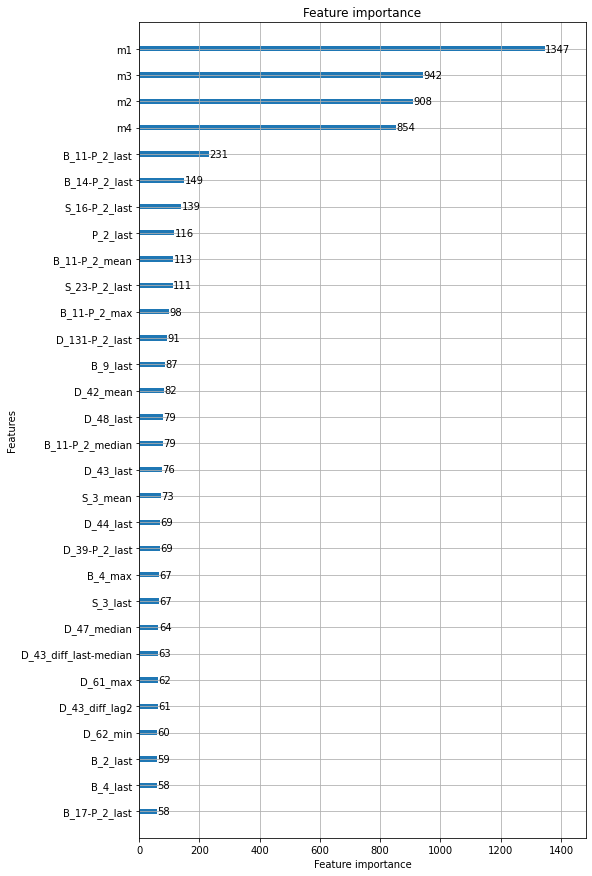

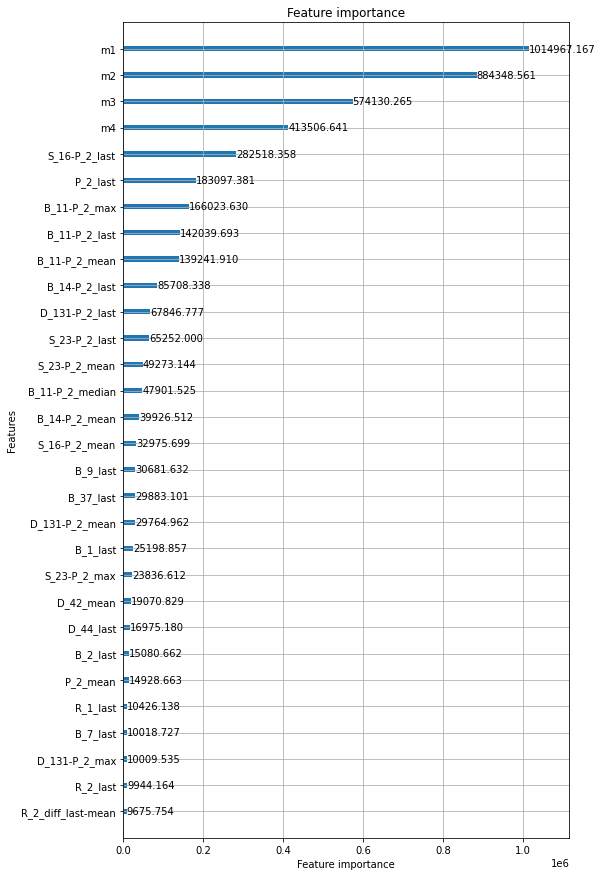

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.789765	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.921195


[100]	valid_0's amex_metric: 0.789442	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.922106


[150]	valid_0's amex_metric: 0.791352	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923064


[200]	valid_0's amex_metric: 0.792694	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924064


[250]	valid_0's amex_metric: 0.793799	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924507


[300]	valid_0's amex_metric: 0.79468	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.924839


[350]	valid_0's amex_metric: 0.795864	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924978


[400]	valid_0's amex_metric: 0.795869	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925072


[450]	valid_0's amex_metric: 0.795998	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.925119


[500]	valid_0's amex_metric: 0.795763	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.92507


[550]	valid_0's amex_metric: 0.79557	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925062


[600]	valid_0's amex_metric: 0.795528	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.925062


[650]	valid_0's amex_metric: 0.795741	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.925068


[700]	valid_0's amex_metric: 0.795584	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925048


[750]	valid_0's amex_metric: 0.795258	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.925027


[800]	valid_0's amex_metric: 0.795983	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925006


[850]	valid_0's amex_metric: 0.795384	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924984


[900]	valid_0's amex_metric: 0.795404	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924984


[950]	valid_0's amex_metric: 0.795267	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.924962


[1000]	valid_0's amex_metric: 0.79595	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924939


[1050]	valid_0's amex_metric: 0.795584	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924923


[1100]	valid_0's amex_metric: 0.795519	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924919


[1150]	valid_0's amex_metric: 0.795291	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924882


[1200]	valid_0's amex_metric: 0.79529	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924882


[1250]	valid_0's amex_metric: 0.795536	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924867


[1300]	valid_0's amex_metric: 0.795617	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.92482


[1350]	valid_0's amex_metric: 0.795571	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.924812


[1400]	valid_0's amex_metric: 0.795688	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.924793


[1450]	valid_0's amex_metric: 0.795853	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.924787


[1500]	valid_0's amex_metric: 0.796148	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924789


[1550]	valid_0's amex_metric: 0.795825	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924772


[1600]	valid_0's amex_metric: 0.795575	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.924777


[1650]	valid_0's amex_metric: 0.795409	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.92474


[1700]	valid_0's amex_metric: 0.795327	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924744


[1750]	valid_0's amex_metric: 0.794804	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924751


[1800]	valid_0's amex_metric: 0.794703	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924717


[1850]	valid_0's amex_metric: 0.794863	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.9247


[1900]	valid_0's amex_metric: 0.795541	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.92471


[1950]	valid_0's amex_metric: 0.79524	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924697


[2000]	valid_0's amex_metric: 0.795151	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924688


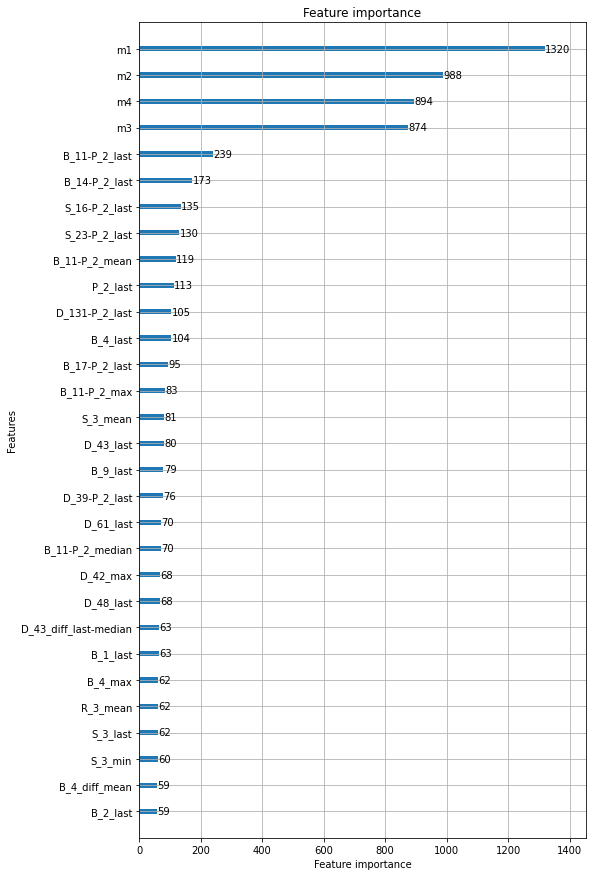

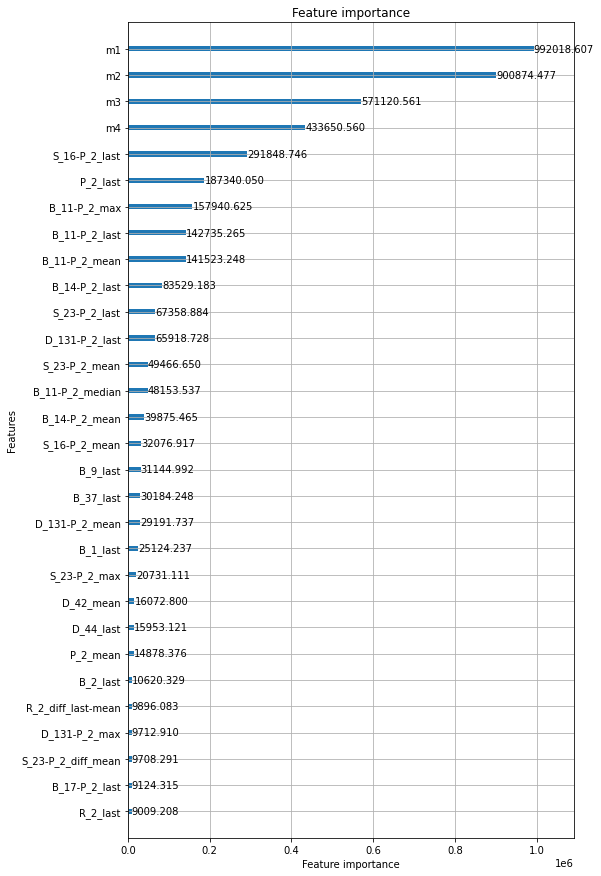

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.786707	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.920254


[100]	valid_0's amex_metric: 0.788382	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.921289


[150]	valid_0's amex_metric: 0.790433	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.922363


[200]	valid_0's amex_metric: 0.793019	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.923327


[250]	valid_0's amex_metric: 0.793047	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.923803


[300]	valid_0's amex_metric: 0.793013	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924198


[350]	valid_0's amex_metric: 0.79294	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.92439


[400]	valid_0's amex_metric: 0.793491	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924523


[450]	valid_0's amex_metric: 0.793187	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924631


[500]	valid_0's amex_metric: 0.793287	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.92462


[550]	valid_0's amex_metric: 0.793125	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.92459


[600]	valid_0's amex_metric: 0.793237	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.924603


[650]	valid_0's amex_metric: 0.793157	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924613


[700]	valid_0's amex_metric: 0.793192	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.92464


[750]	valid_0's amex_metric: 0.793167	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924633


[800]	valid_0's amex_metric: 0.79347	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.924607


[850]	valid_0's amex_metric: 0.793377	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.924589


[900]	valid_0's amex_metric: 0.793126	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924593


[950]	valid_0's amex_metric: 0.793522	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924585


[1000]	valid_0's amex_metric: 0.793261	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924569


[1050]	valid_0's amex_metric: 0.792619	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.924547


[1100]	valid_0's amex_metric: 0.792589	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924529


[1150]	valid_0's amex_metric: 0.792235	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924536


[1200]	valid_0's amex_metric: 0.792185	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924521


[1250]	valid_0's amex_metric: 0.792572	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924495


[1300]	valid_0's amex_metric: 0.792622	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924467


[1350]	valid_0's amex_metric: 0.792544	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924438


[1400]	valid_0's amex_metric: 0.791922	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.924414


[1450]	valid_0's amex_metric: 0.791634	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924385


[1500]	valid_0's amex_metric: 0.791594	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.92439


[1550]	valid_0's amex_metric: 0.791596	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.924352


[1600]	valid_0's amex_metric: 0.792009	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.924337


[1650]	valid_0's amex_metric: 0.792123	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924312


[1700]	valid_0's amex_metric: 0.792238	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.92429


[1750]	valid_0's amex_metric: 0.792273	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.924276


[1800]	valid_0's amex_metric: 0.791748	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.924276


[1850]	valid_0's amex_metric: 0.791781	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.924259


[1900]	valid_0's amex_metric: 0.79163	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.924251


[1950]	valid_0's amex_metric: 0.791658	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924222


[2000]	valid_0's amex_metric: 0.791642	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924192


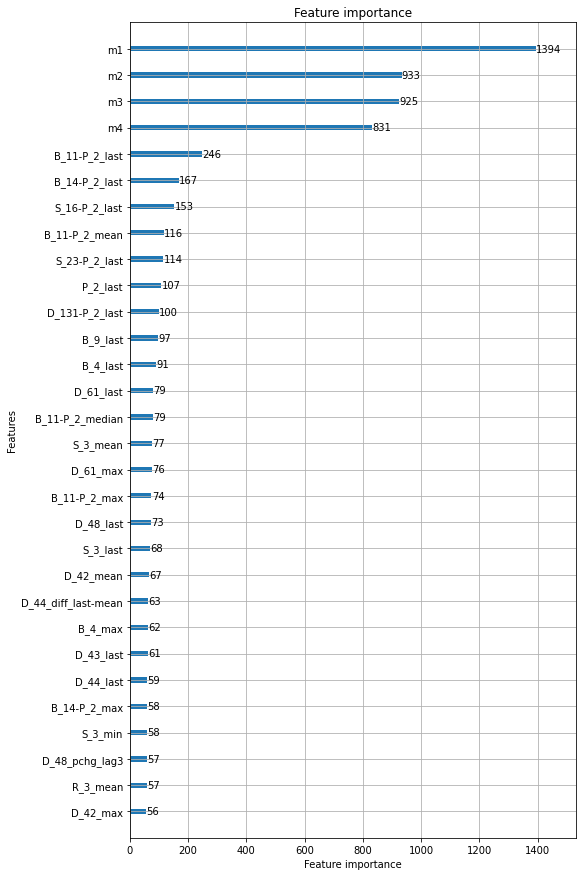

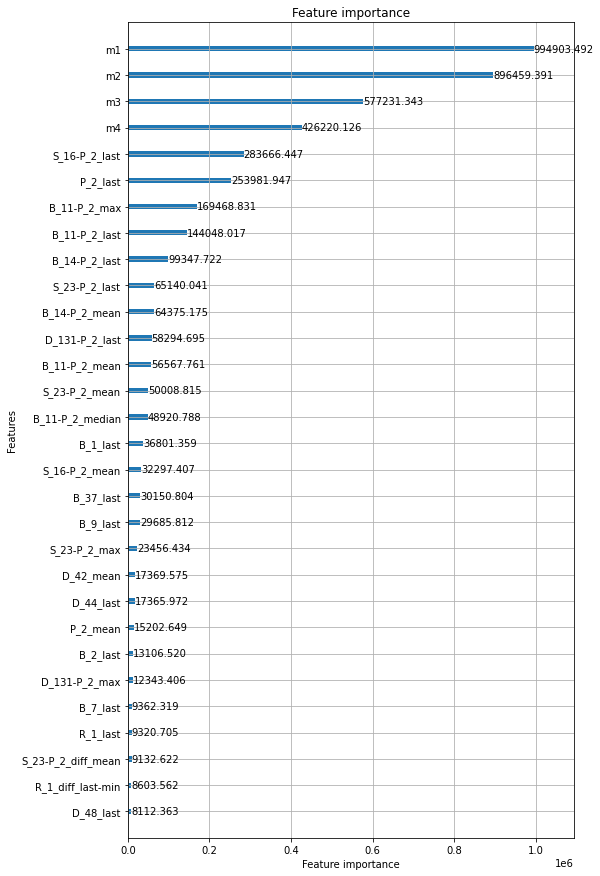

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.793843	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.921749


[100]	valid_0's amex_metric: 0.794822	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.922529


[150]	valid_0's amex_metric: 0.796731	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.923485


[200]	valid_0's amex_metric: 0.798536	valid_0's recall_at4: 0.672628	valid_0's norm_gini: 0.924444


[250]	valid_0's amex_metric: 0.798974	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.924942


[300]	valid_0's amex_metric: 0.799601	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.925271


[350]	valid_0's amex_metric: 0.799696	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.925419


[400]	valid_0's amex_metric: 0.799992	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.925462


[450]	valid_0's amex_metric: 0.800429	valid_0's recall_at4: 0.675363	valid_0's norm_gini: 0.925496


[500]	valid_0's amex_metric: 0.799938	valid_0's recall_at4: 0.674395	valid_0's norm_gini: 0.925481


[550]	valid_0's amex_metric: 0.800146	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.925477


[600]	valid_0's amex_metric: 0.799404	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.925507


[650]	valid_0's amex_metric: 0.799398	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.925536


[700]	valid_0's amex_metric: 0.799629	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.925495


[750]	valid_0's amex_metric: 0.799366	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.925515


[800]	valid_0's amex_metric: 0.798892	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.925494


[850]	valid_0's amex_metric: 0.799072	valid_0's recall_at4: 0.67267	valid_0's norm_gini: 0.925474


[900]	valid_0's amex_metric: 0.79883	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.925452


[950]	valid_0's amex_metric: 0.799291	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.925406


[1000]	valid_0's amex_metric: 0.79899	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925394


[1050]	valid_0's amex_metric: 0.79892	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.925381


[1100]	valid_0's amex_metric: 0.799212	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.925375


[1150]	valid_0's amex_metric: 0.798922	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.925342


[1200]	valid_0's amex_metric: 0.799184	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.925319


[1250]	valid_0's amex_metric: 0.799067	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.925295


[1300]	valid_0's amex_metric: 0.799102	valid_0's recall_at4: 0.672922	valid_0's norm_gini: 0.925281


[1350]	valid_0's amex_metric: 0.798726	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.925287


[1400]	valid_0's amex_metric: 0.798866	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.925272


[1450]	valid_0's amex_metric: 0.799324	valid_0's recall_at4: 0.673385	valid_0's norm_gini: 0.925263


[1500]	valid_0's amex_metric: 0.799002	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.925251


[1550]	valid_0's amex_metric: 0.798489	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925233


[1600]	valid_0's amex_metric: 0.79843	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.9252


[1650]	valid_0's amex_metric: 0.798802	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.925187


[1700]	valid_0's amex_metric: 0.798305	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.925161


[1750]	valid_0's amex_metric: 0.798024	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925145


[1800]	valid_0's amex_metric: 0.797984	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.925107


[1850]	valid_0's amex_metric: 0.797614	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925082


[1900]	valid_0's amex_metric: 0.797565	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925069


[1950]	valid_0's amex_metric: 0.798035	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.925041


[2000]	valid_0's amex_metric: 0.797966	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925029


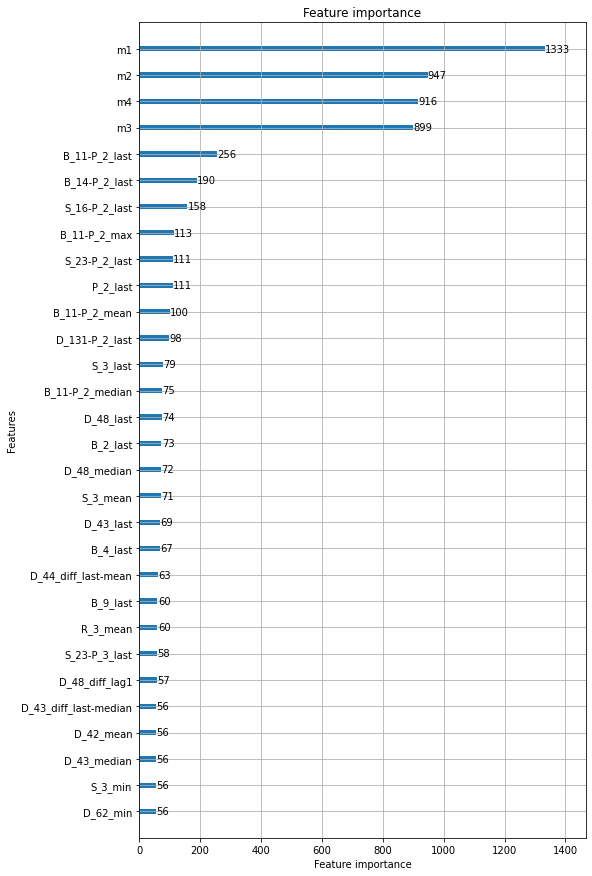

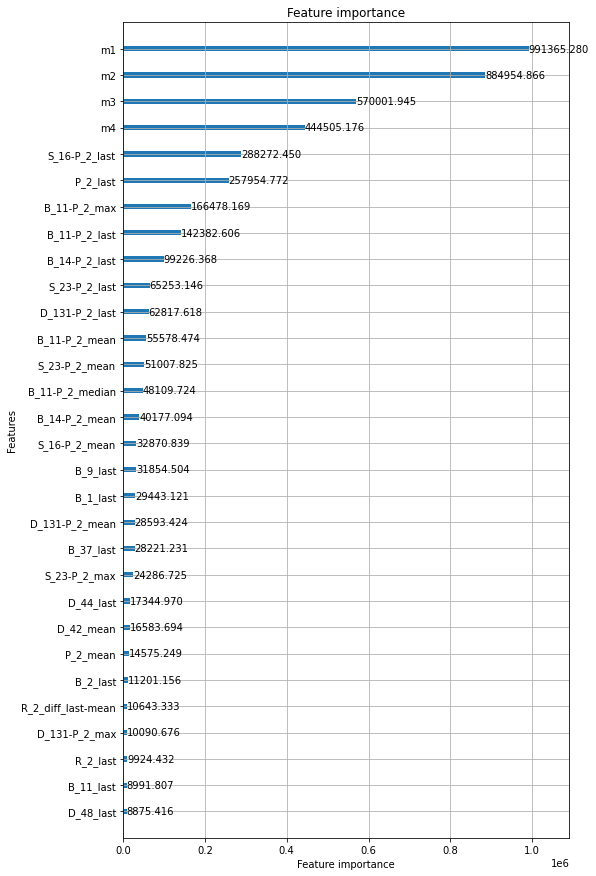

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.793926	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.92242


[100]	valid_0's amex_metric: 0.794277	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.923247


[150]	valid_0's amex_metric: 0.79596	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.924088


[200]	valid_0's amex_metric: 0.797149	valid_0's recall_at4: 0.669388	valid_0's norm_gini: 0.92491


[250]	valid_0's amex_metric: 0.797865	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925332


[300]	valid_0's amex_metric: 0.798704	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925664


[350]	valid_0's amex_metric: 0.799053	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.925772


[400]	valid_0's amex_metric: 0.798797	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.92585


[450]	valid_0's amex_metric: 0.799303	valid_0's recall_at4: 0.67267	valid_0's norm_gini: 0.925936


[500]	valid_0's amex_metric: 0.798695	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.92594


[550]	valid_0's amex_metric: 0.798299	valid_0's recall_at4: 0.67065	valid_0's norm_gini: 0.925948


[600]	valid_0's amex_metric: 0.799071	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.925976


[650]	valid_0's amex_metric: 0.798574	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.925993


[700]	valid_0's amex_metric: 0.799208	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.925998


[750]	valid_0's amex_metric: 0.799225	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.925991


[800]	valid_0's amex_metric: 0.79944	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.926001


[850]	valid_0's amex_metric: 0.799502	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925997


[900]	valid_0's amex_metric: 0.799149	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.926007


[950]	valid_0's amex_metric: 0.799092	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.925977


[1000]	valid_0's amex_metric: 0.799485	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925963


[1050]	valid_0's amex_metric: 0.799243	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.925943


[1100]	valid_0's amex_metric: 0.79888	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.925933


[1150]	valid_0's amex_metric: 0.799237	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.92593


[1200]	valid_0's amex_metric: 0.798676	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.925902


[1250]	valid_0's amex_metric: 0.798758	valid_0's recall_at4: 0.671618	valid_0's norm_gini: 0.925899


[1300]	valid_0's amex_metric: 0.798644	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.925881


[1350]	valid_0's amex_metric: 0.798496	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.92588


[1400]	valid_0's amex_metric: 0.79819	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.925856


[1450]	valid_0's amex_metric: 0.798295	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.925856


[1500]	valid_0's amex_metric: 0.798569	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.925815


[1550]	valid_0's amex_metric: 0.798283	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.925791


[1600]	valid_0's amex_metric: 0.798216	valid_0's recall_at4: 0.67065	valid_0's norm_gini: 0.925782


[1650]	valid_0's amex_metric: 0.798334	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925766


[1700]	valid_0's amex_metric: 0.798267	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.925758


[1750]	valid_0's amex_metric: 0.798481	valid_0's recall_at4: 0.671239	valid_0's norm_gini: 0.925722


[1800]	valid_0's amex_metric: 0.798047	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925696


[1850]	valid_0's amex_metric: 0.797492	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.92568


[1900]	valid_0's amex_metric: 0.797889	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925675


[1950]	valid_0's amex_metric: 0.798	valid_0's recall_at4: 0.670356	valid_0's norm_gini: 0.925645


[2000]	valid_0's amex_metric: 0.797845	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925628


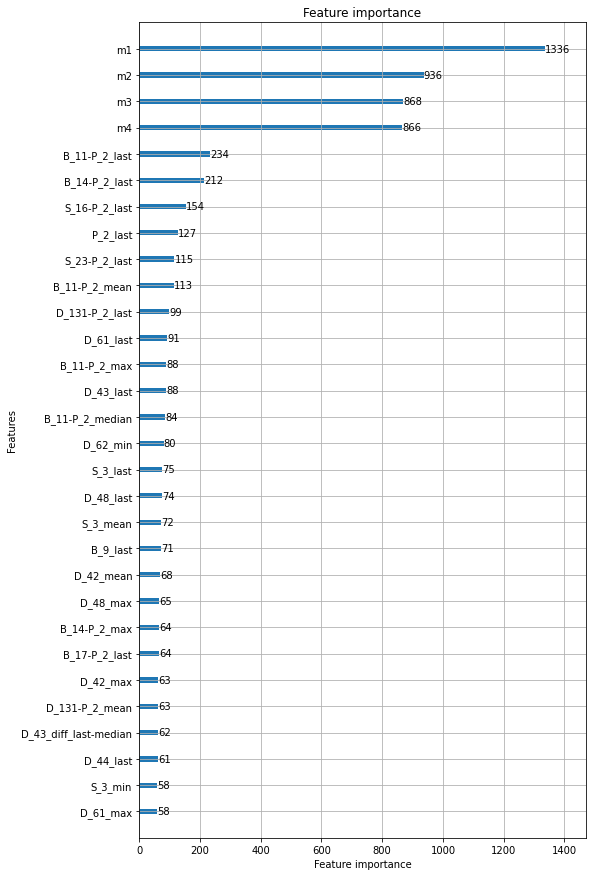

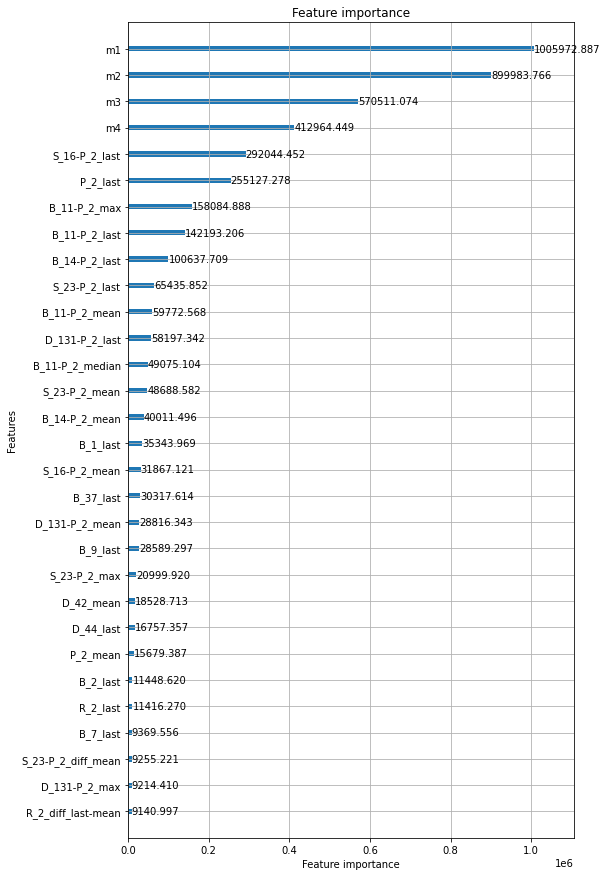

Training time: 19.969323388735454 min.
OOF recall_at4: 0.6676120106372235
OOF normalized_gini: 0.9249933778148546
OOF competition metric: 0.796302694226039


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


[50]	valid_0's amex_metric: 0.789656	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.919714


[100]	valid_0's amex_metric: 0.790896	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.920764


[150]	valid_0's amex_metric: 0.792664	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.921775


[200]	valid_0's amex_metric: 0.793417	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.922735


[250]	valid_0's amex_metric: 0.793815	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923278


[300]	valid_0's amex_metric: 0.795114	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.923604


[350]	valid_0's amex_metric: 0.79561	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.923754


[400]	valid_0's amex_metric: 0.795383	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.923847


[450]	valid_0's amex_metric: 0.795442	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.923923


[500]	valid_0's amex_metric: 0.795643	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.923945


[550]	valid_0's amex_metric: 0.795768	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.923944


[600]	valid_0's amex_metric: 0.795545	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.92396


[650]	valid_0's amex_metric: 0.795655	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.92397


[700]	valid_0's amex_metric: 0.795279	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.923975


[750]	valid_0's amex_metric: 0.795699	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.923974


[800]	valid_0's amex_metric: 0.795654	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.923968


[850]	valid_0's amex_metric: 0.795301	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.923936


[900]	valid_0's amex_metric: 0.795364	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.923935


[950]	valid_0's amex_metric: 0.795662	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.9239


[1000]	valid_0's amex_metric: 0.79479	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.923882


[1050]	valid_0's amex_metric: 0.794504	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923856


[1100]	valid_0's amex_metric: 0.794603	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.923845


[1150]	valid_0's amex_metric: 0.794806	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.923829


[1200]	valid_0's amex_metric: 0.794338	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.923818


[1250]	valid_0's amex_metric: 0.794283	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923792


[1300]	valid_0's amex_metric: 0.794428	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.923788


[1350]	valid_0's amex_metric: 0.794334	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.923769


[1400]	valid_0's amex_metric: 0.794434	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.923758


[1450]	valid_0's amex_metric: 0.794596	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.923746


[1500]	valid_0's amex_metric: 0.794796	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923766


[1550]	valid_0's amex_metric: 0.79479	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923754


[1600]	valid_0's amex_metric: 0.794805	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.923743


[1650]	valid_0's amex_metric: 0.794582	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.923718


[1700]	valid_0's amex_metric: 0.79483	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923708


[1750]	valid_0's amex_metric: 0.794426	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.9237


[1800]	valid_0's amex_metric: 0.79406	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923684


[1850]	valid_0's amex_metric: 0.794231	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923688


[1900]	valid_0's amex_metric: 0.794215	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923656


[1950]	valid_0's amex_metric: 0.793887	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923633


[2000]	valid_0's amex_metric: 0.793877	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923613


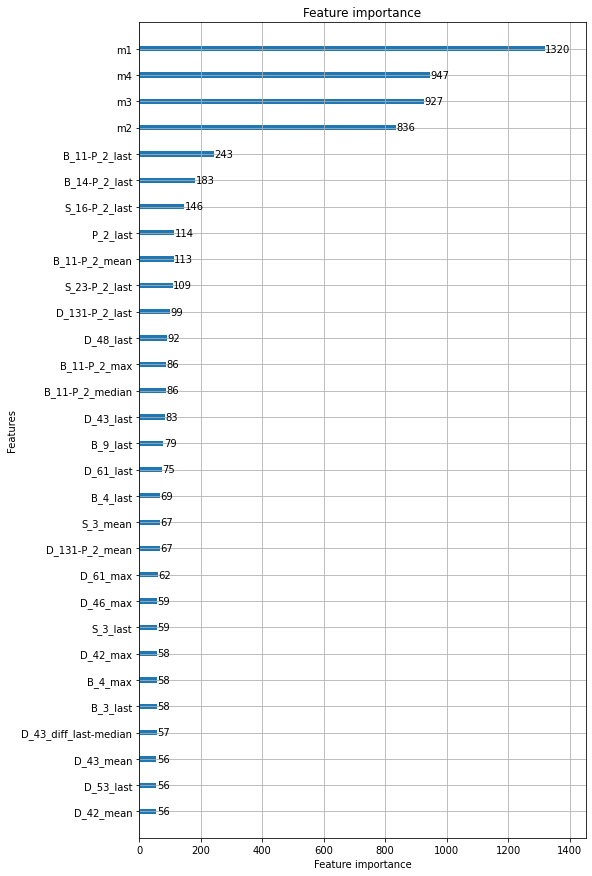

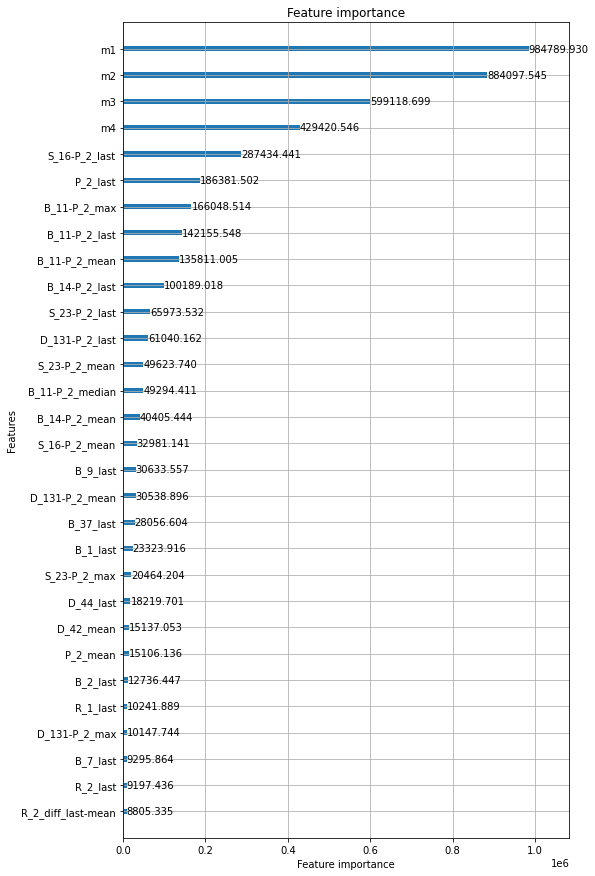

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.786885	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.921703


[100]	valid_0's amex_metric: 0.789421	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.922526


[150]	valid_0's amex_metric: 0.790896	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.923498


[200]	valid_0's amex_metric: 0.792842	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924319


[250]	valid_0's amex_metric: 0.793207	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924712


[300]	valid_0's amex_metric: 0.79406	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925029


[350]	valid_0's amex_metric: 0.794191	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.925208


[400]	valid_0's amex_metric: 0.795163	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925342


[450]	valid_0's amex_metric: 0.794791	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925439


[500]	valid_0's amex_metric: 0.794694	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925457


[550]	valid_0's amex_metric: 0.794683	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.925477


[600]	valid_0's amex_metric: 0.794627	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.92549


[650]	valid_0's amex_metric: 0.794829	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925515


[700]	valid_0's amex_metric: 0.794623	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925526


[750]	valid_0's amex_metric: 0.79481	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.925521


[800]	valid_0's amex_metric: 0.794956	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925517


[850]	valid_0's amex_metric: 0.79489	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.925512


[900]	valid_0's amex_metric: 0.795114	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.925539


[950]	valid_0's amex_metric: 0.795048	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.925533


[1000]	valid_0's amex_metric: 0.794353	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.92549


[1050]	valid_0's amex_metric: 0.794801	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925461


[1100]	valid_0's amex_metric: 0.794228	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.925451


[1150]	valid_0's amex_metric: 0.794492	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.92543


[1200]	valid_0's amex_metric: 0.794353	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925405


[1250]	valid_0's amex_metric: 0.794209	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.92537


[1300]	valid_0's amex_metric: 0.794137	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.925353


[1350]	valid_0's amex_metric: 0.794261	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.925347


[1400]	valid_0's amex_metric: 0.794058	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.92532


[1450]	valid_0's amex_metric: 0.794126	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.925288


[1500]	valid_0's amex_metric: 0.793726	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.925246


[1550]	valid_0's amex_metric: 0.793892	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.92524


[1600]	valid_0's amex_metric: 0.79384	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925221


[1650]	valid_0's amex_metric: 0.794062	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.925203


[1700]	valid_0's amex_metric: 0.794033	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.925187


[1750]	valid_0's amex_metric: 0.793914	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.925158


[1800]	valid_0's amex_metric: 0.79401	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.925141


[1850]	valid_0's amex_metric: 0.794373	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.92511


[1900]	valid_0's amex_metric: 0.793646	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.925085


[1950]	valid_0's amex_metric: 0.793478	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.925087


[2000]	valid_0's amex_metric: 0.793564	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.925047


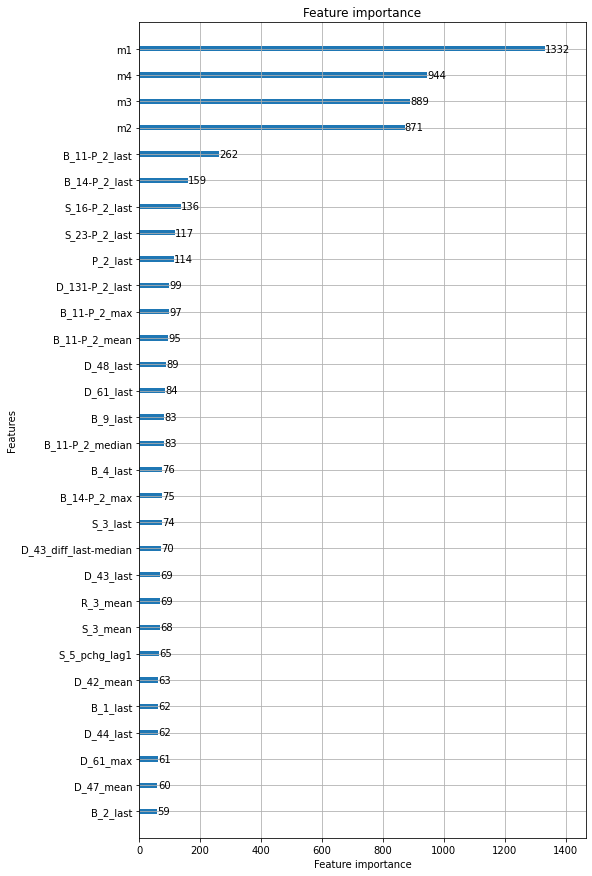

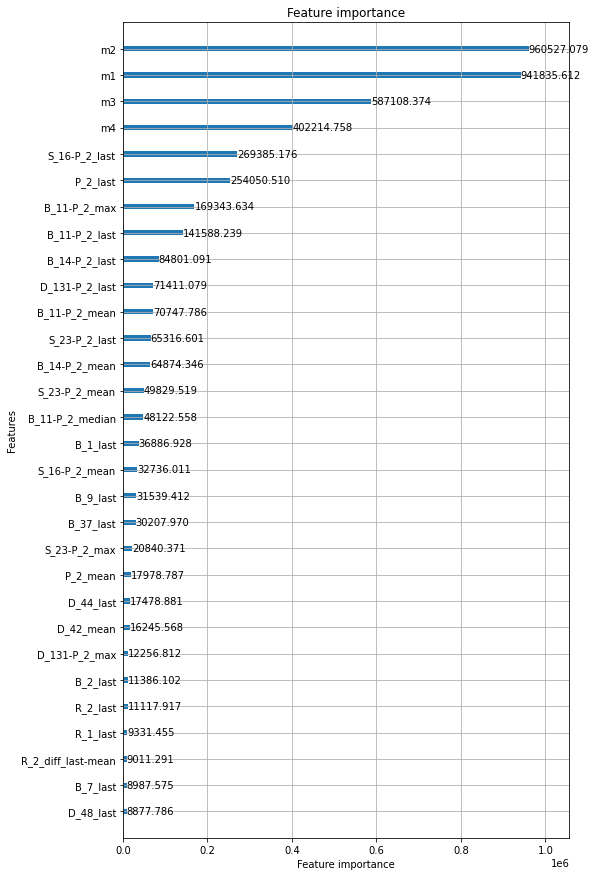

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.792244	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.921188


[100]	valid_0's amex_metric: 0.794528	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.922094


[150]	valid_0's amex_metric: 0.796249	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.92318


[200]	valid_0's amex_metric: 0.79769	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.924169


[250]	valid_0's amex_metric: 0.797647	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.924671


[300]	valid_0's amex_metric: 0.798057	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925072


[350]	valid_0's amex_metric: 0.798793	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925281


[400]	valid_0's amex_metric: 0.798795	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925411


[450]	valid_0's amex_metric: 0.798779	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925505


[500]	valid_0's amex_metric: 0.798906	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925508


[550]	valid_0's amex_metric: 0.798762	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925513


[600]	valid_0's amex_metric: 0.798733	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925539


[650]	valid_0's amex_metric: 0.798366	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925563


[700]	valid_0's amex_metric: 0.798614	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925554


[750]	valid_0's amex_metric: 0.7987	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925558


[800]	valid_0's amex_metric: 0.798734	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925541


[850]	valid_0's amex_metric: 0.798637	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925557


[900]	valid_0's amex_metric: 0.799061	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925564


[950]	valid_0's amex_metric: 0.798974	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.92556


[1000]	valid_0's amex_metric: 0.798968	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925547


[1050]	valid_0's amex_metric: 0.798808	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925564


[1100]	valid_0's amex_metric: 0.79923	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925566


[1150]	valid_0's amex_metric: 0.799065	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925573


[1200]	valid_0's amex_metric: 0.799113	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925542


[1250]	valid_0's amex_metric: 0.798724	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925522


[1300]	valid_0's amex_metric: 0.798911	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925516


[1350]	valid_0's amex_metric: 0.799018	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.92552


[1400]	valid_0's amex_metric: 0.798814	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925492


[1450]	valid_0's amex_metric: 0.798595	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925474


[1500]	valid_0's amex_metric: 0.798588	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92546


[1550]	valid_0's amex_metric: 0.79816	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925445


[1600]	valid_0's amex_metric: 0.798173	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.92543


[1650]	valid_0's amex_metric: 0.798007	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925392


[1700]	valid_0's amex_metric: 0.7977	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925367


[1750]	valid_0's amex_metric: 0.797261	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.92533


[1800]	valid_0's amex_metric: 0.797194	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.925323


[1850]	valid_0's amex_metric: 0.79729	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925306


[1900]	valid_0's amex_metric: 0.797354	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925307


[1950]	valid_0's amex_metric: 0.797497	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925297


[2000]	valid_0's amex_metric: 0.797655	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925277


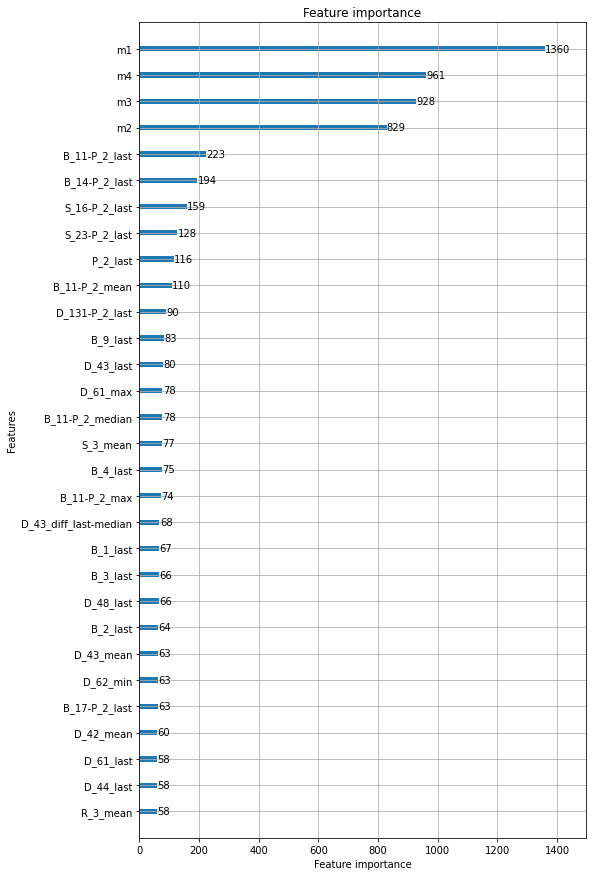

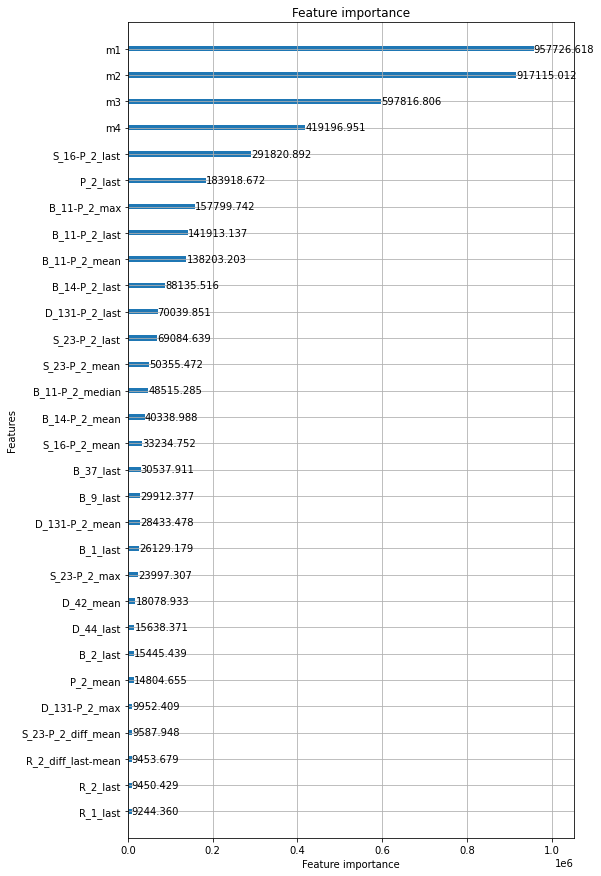

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.797735	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.924568


[100]	valid_0's amex_metric: 0.799344	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.925387


[150]	valid_0's amex_metric: 0.800839	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.926357


[200]	valid_0's amex_metric: 0.802921	valid_0's recall_at4: 0.678561	valid_0's norm_gini: 0.92728


[250]	valid_0's amex_metric: 0.803791	valid_0's recall_at4: 0.679865	valid_0's norm_gini: 0.927717


[300]	valid_0's amex_metric: 0.80407	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.928065


[350]	valid_0's amex_metric: 0.804609	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928217


[400]	valid_0's amex_metric: 0.804661	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928321


[450]	valid_0's amex_metric: 0.804953	valid_0's recall_at4: 0.681548	valid_0's norm_gini: 0.928357


[500]	valid_0's amex_metric: 0.804739	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928351


[550]	valid_0's amex_metric: 0.805028	valid_0's recall_at4: 0.681717	valid_0's norm_gini: 0.92834


[600]	valid_0's amex_metric: 0.804628	valid_0's recall_at4: 0.680875	valid_0's norm_gini: 0.928381


[650]	valid_0's amex_metric: 0.804691	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928381


[700]	valid_0's amex_metric: 0.805136	valid_0's recall_at4: 0.681885	valid_0's norm_gini: 0.928387


[750]	valid_0's amex_metric: 0.804885	valid_0's recall_at4: 0.68138	valid_0's norm_gini: 0.92839


[800]	valid_0's amex_metric: 0.804884	valid_0's recall_at4: 0.68138	valid_0's norm_gini: 0.928389


[850]	valid_0's amex_metric: 0.804793	valid_0's recall_at4: 0.681212	valid_0's norm_gini: 0.928374


[900]	valid_0's amex_metric: 0.804819	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.928385


[950]	valid_0's amex_metric: 0.804774	valid_0's recall_at4: 0.68117	valid_0's norm_gini: 0.928379


[1000]	valid_0's amex_metric: 0.804796	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.928338


[1050]	valid_0's amex_metric: 0.804251	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928341


[1100]	valid_0's amex_metric: 0.804682	valid_0's recall_at4: 0.681044	valid_0's norm_gini: 0.928321


[1150]	valid_0's amex_metric: 0.804432	valid_0's recall_at4: 0.680581	valid_0's norm_gini: 0.928284


[1200]	valid_0's amex_metric: 0.803993	valid_0's recall_at4: 0.679739	valid_0's norm_gini: 0.928247


[1250]	valid_0's amex_metric: 0.803795	valid_0's recall_at4: 0.67936	valid_0's norm_gini: 0.928229


[1300]	valid_0's amex_metric: 0.803808	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.928213


[1350]	valid_0's amex_metric: 0.804121	valid_0's recall_at4: 0.680034	valid_0's norm_gini: 0.928209


[1400]	valid_0's amex_metric: 0.803757	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928196


[1450]	valid_0's amex_metric: 0.803752	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928186


[1500]	valid_0's amex_metric: 0.803964	valid_0's recall_at4: 0.679739	valid_0's norm_gini: 0.92819


[1550]	valid_0's amex_metric: 0.803812	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.928179


[1600]	valid_0's amex_metric: 0.803693	valid_0's recall_at4: 0.679234	valid_0's norm_gini: 0.928152


[1650]	valid_0's amex_metric: 0.803915	valid_0's recall_at4: 0.679697	valid_0's norm_gini: 0.928134


[1700]	valid_0's amex_metric: 0.803767	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.928131


[1750]	valid_0's amex_metric: 0.80346	valid_0's recall_at4: 0.678813	valid_0's norm_gini: 0.928107


[1800]	valid_0's amex_metric: 0.803455	valid_0's recall_at4: 0.678813	valid_0's norm_gini: 0.928096


[1850]	valid_0's amex_metric: 0.80317	valid_0's recall_at4: 0.678266	valid_0's norm_gini: 0.928074


[1900]	valid_0's amex_metric: 0.803427	valid_0's recall_at4: 0.678813	valid_0's norm_gini: 0.928041


[1950]	valid_0's amex_metric: 0.803485	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.928029


[2000]	valid_0's amex_metric: 0.803199	valid_0's recall_at4: 0.678393	valid_0's norm_gini: 0.928005


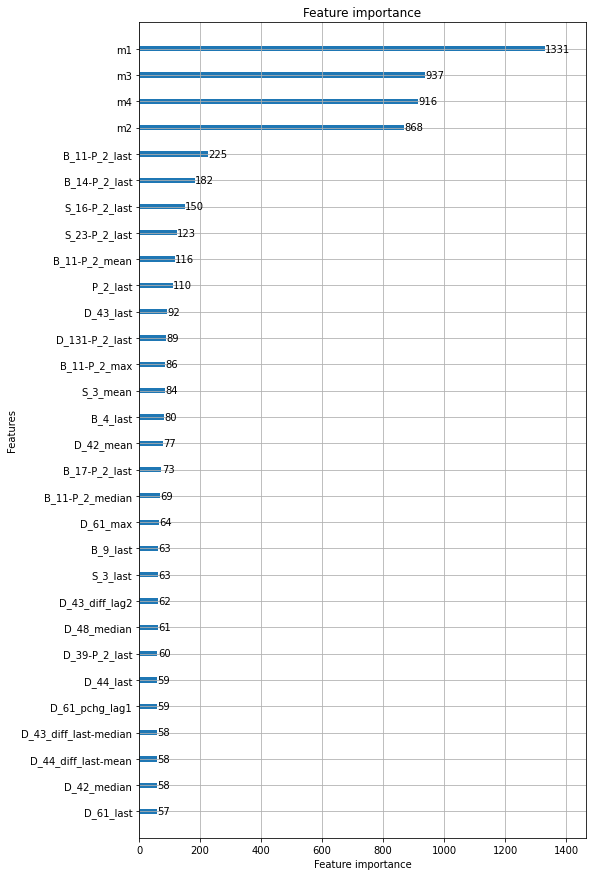

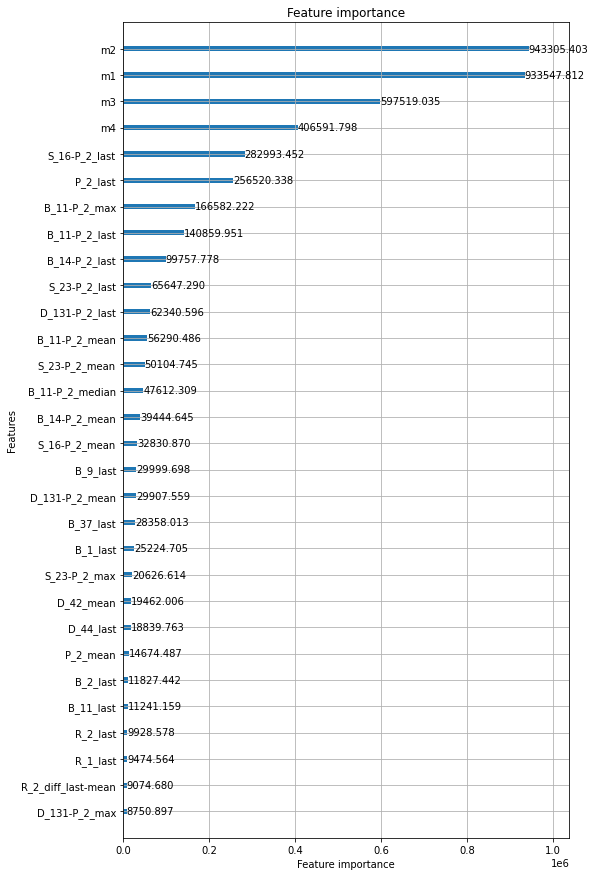

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.790049	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.920641


[100]	valid_0's amex_metric: 0.791628	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.921568


[150]	valid_0's amex_metric: 0.793307	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.922486


[200]	valid_0's amex_metric: 0.793716	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.923389


[250]	valid_0's amex_metric: 0.794842	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.923789


[300]	valid_0's amex_metric: 0.794903	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.924122


[350]	valid_0's amex_metric: 0.795062	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924271


[400]	valid_0's amex_metric: 0.795955	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924374


[450]	valid_0's amex_metric: 0.794996	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.924433


[500]	valid_0's amex_metric: 0.795289	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.92443


[550]	valid_0's amex_metric: 0.795203	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.924427


[600]	valid_0's amex_metric: 0.795614	valid_0's recall_at4: 0.666737	valid_0's norm_gini: 0.924492


[650]	valid_0's amex_metric: 0.795858	valid_0's recall_at4: 0.6672	valid_0's norm_gini: 0.924517


[700]	valid_0's amex_metric: 0.795425	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.924491


[750]	valid_0's amex_metric: 0.795447	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924494


[800]	valid_0's amex_metric: 0.795426	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.924493


[850]	valid_0's amex_metric: 0.794727	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924484


[900]	valid_0's amex_metric: 0.795139	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924467


[950]	valid_0's amex_metric: 0.795188	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.924439


[1000]	valid_0's amex_metric: 0.794582	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924404


[1050]	valid_0's amex_metric: 0.794763	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.924389


[1100]	valid_0's amex_metric: 0.794753	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.924369


[1150]	valid_0's amex_metric: 0.794439	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924371


[1200]	valid_0's amex_metric: 0.794395	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.924325


[1250]	valid_0's amex_metric: 0.794735	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.92429


[1300]	valid_0's amex_metric: 0.794937	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924274


[1350]	valid_0's amex_metric: 0.795062	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924271


[1400]	valid_0's amex_metric: 0.794659	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924265


[1450]	valid_0's amex_metric: 0.794496	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.924275


[1500]	valid_0's amex_metric: 0.794304	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.92427


[1550]	valid_0's amex_metric: 0.794549	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.924254


[1600]	valid_0's amex_metric: 0.794447	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.92422


[1650]	valid_0's amex_metric: 0.794537	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.924188


[1700]	valid_0's amex_metric: 0.794704	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.924187


[1750]	valid_0's amex_metric: 0.794175	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924181


[1800]	valid_0's amex_metric: 0.794364	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.924137


[1850]	valid_0's amex_metric: 0.794226	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924113


[1900]	valid_0's amex_metric: 0.794049	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.924096


[1950]	valid_0's amex_metric: 0.793825	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.92407


[2000]	valid_0's amex_metric: 0.793999	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924039


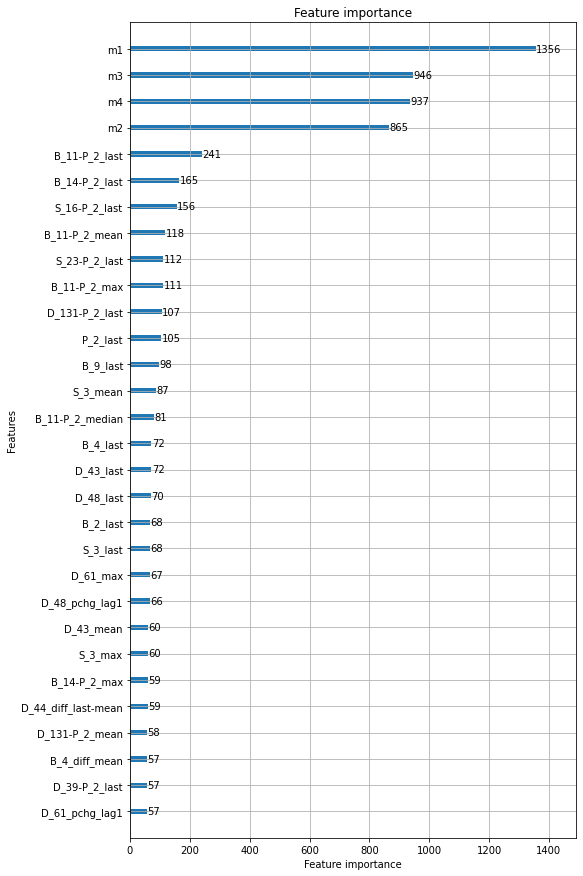

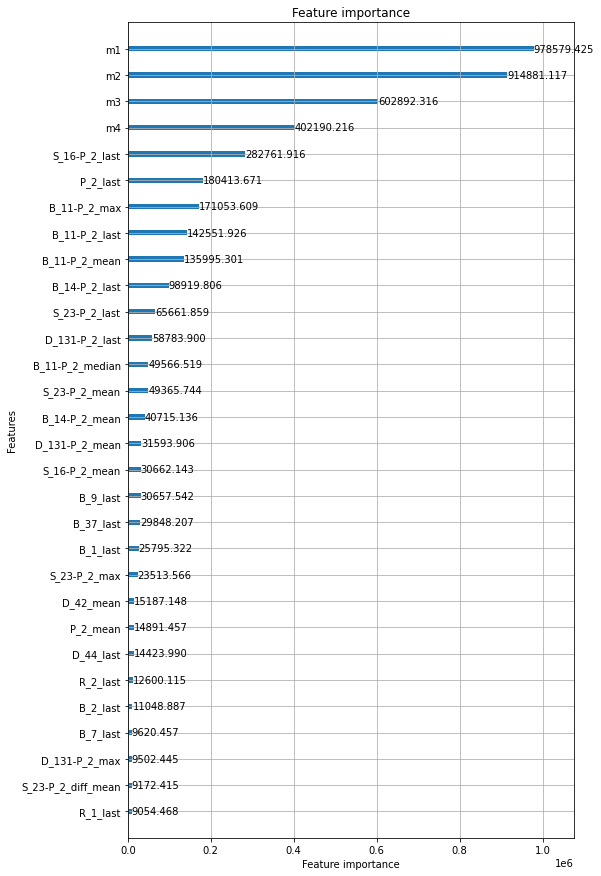

Training time: 19.85684305826823 min.
OOF recall_at4: 0.6678728919109974
OOF normalized_gini: 0.9250282729231974
OOF competition metric: 0.7964505824170974


CPU times: user 13h 51min 52s, sys: 1min 32s, total: 13h 53min 24s
Wall time: 1h 5s


In [12]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    oof1 = pd.read_csv(path1+f"/oof-cv{repetition}.csv")
    oof2 = pd.read_csv(path2+f"/oof-cv{repetition}.csv")
    oof3 = pd.read_csv(path3+f"/oof-cv{repetition}.csv")
    oof4 = pd.read_csv(path4+f"/oof-cv{repetition}.csv")
    _train["m1"] = oof1["pred"].values
    _train["m2"] = oof2["pred"].values
    _train["m3"] = oof3["pred"].values
    _train["m4"] = oof4["pred"].values
    if "m1" not in input_feats:
        input_feats.append("m1")
    if "m2" not in input_feats:
        input_feats.append("m2")
    if "m3" not in input_feats:
        input_feats.append("m3")
    if "m4" not in input_feats:
        input_feats.append("m4")
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [13]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.666855,0.925003,0.795929
1,0.667612,0.924993,0.796303
2,0.667873,0.925028,0.796451



mean:


recall_at4    0.667447
gini          0.925008
metric        0.796227
dtype: float64


std:


recall_at4    0.000529
gini          0.000018
metric        0.000269
dtype: float64

In [14]:
del train
gc.collect()

21

***
## make predictions and submit

In [15]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [16]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [17]:
# path of model predictions
path1 = "../data/subs/lgbm-dart-bce-dsv06"
path2 = "../data/subs/lgbm-dart-xtree-bce-dsv06"
path3 = "../data/subs/xgboost-dsv06"
path4 = "../data/subs/catboost-dsv06"

In [18]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    sub1 = pd.read_csv(path1+f"/submission-cv{repetition}.csv")
    sub2 = pd.read_csv(path2+f"/submission-cv{repetition}.csv")
    sub3 = pd.read_csv(path3+f"/submission-cv{repetition}.csv")
    sub4 = pd.read_csv(path4+f"/submission-cv{repetition}.csv")
    
    test["m1"] = sub1["prediction"].values
    test["m2"] = sub2["prediction"].values
    test["m3"] = sub3["prediction"].values
    test["m4"] = sub4["prediction"].values
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

In [ ]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

***